In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models,layers
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:

from google.colab import drive
import os
import cv2
#cambiar el directorio de google colab a google drive
drive.mount('/content/drive')
#cambiar el directorio de trabajo actual
os.chdir('/content/drive/My Drive/INF_354/examen_final/dataset')
!pwd


Mounted at /content/drive
/content/drive/My Drive/INF_354/examen_final/dataset


# **PARA DATOS DE ENTRENAMIENTO DE 80% Y DE TESTEO DE  20%**

In [177]:
#inicializacionde variables
directory="hojas_papa"
size_test=0.2
image_size=256
channels=3
epocas=100
batch_size=32
nro_clases=3


## **Lectura de datos**

In [178]:
# cargamos los datos
data=tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    #nombre de la carperas
    #labels='inferred',
    #label_mode='int',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(image_size, image_size),
   shuffle = True,
    #mágenes se barajan al cargar
    #seed=123,
    #validation_split=None,
    #subset=None,
    #interpolation='bilinear',
    #follow_links=False,
    #imágenes se recortarán al aspecto de imagen_size para evitar deformacione
    #rop_to_aspect_ratio=False
)


Found 752 files belonging to 3 classes.


In [179]:
clases=data.class_names
print("clases: ",clases)
print("numero de batches (32 ->1bat): ",len(data))
print(data)


clases:  ['Patata___Tizón_tardío', 'Patata___Tizón_temprano', 'Potato___healthy']
numero de batches (32 ->1bat):  24
<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


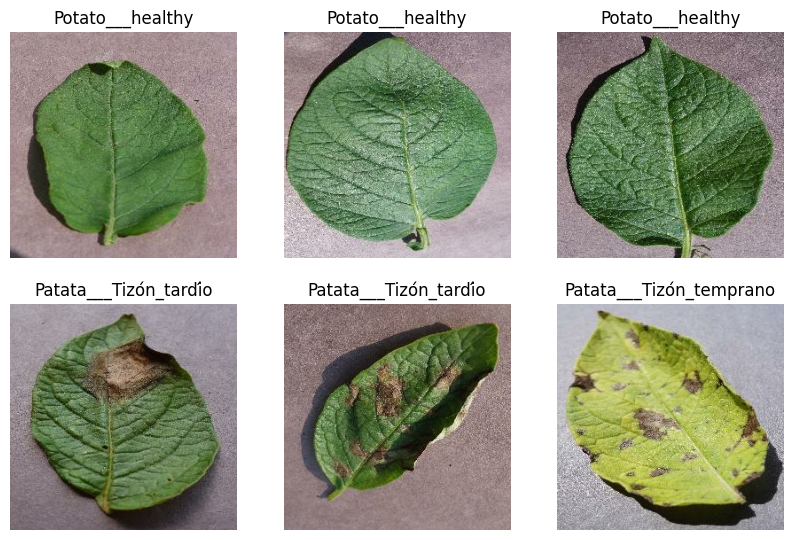

In [180]:
plt.figure(figsize=(10,10))
for images, labels in data.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(clases[labels[i]])
    plt.axis("off")

### **Datos de entrenamiento y testeo**

In [181]:
# shuffle_size determina cuántos elementos se toman aleatoriamente del conjunto de datos para realizar la mezcla (todos se mezclan 1000)
def split_dataset(data,train_split=0.7,val_split=0.1,test_split=0.2,shuffle=True,shuffle_size=10000):
  # se mezclan los datos
  if shuffle:
    data=data.shuffle(shuffle_size, seed=10)

  data_size=len(data)
  train_size=int(train_split*data_size)
  val_size=int(val_split*data_size)

  #se extrae con take y skip para omitir los datos selecionados
  train_data=data.take(train_size)
  val_data=data.skip(train_size).take(val_size)
  test_data=data.skip(train_size).skip(val_size)
  return train_data,val_data,test_data

In [182]:
train_data,val_data,test_data=split_dataset(data)

print("data: ",len(data))
print("train: ",len(train_data))
print("val: ",len(val_data))
print("test: ",len(test_data))
print("numero de batches train (32 ->1bat): ",len(train_data))
print(train_data)

data:  24
train:  16
val:  2
test:  6
numero de batches train (32 ->1bat):  16
<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


almacenamiento de cache, reproducion aleatoria y precarga de datos

In [183]:
# para acelerar el aprendizaje, se optimiza la utilizacion de los recursos de hardware
# El almacenamiento en caché acelera la lectura de los datos desde la memoria, la mezcla aleatoria evita cualquier orden inherente en los datos y la captación previa reduce el tiempo de espera durante el entrenamiento
#prefetch de captación previa para superponer el trabajo de un productor y un consumidor
train_ds=train_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds=val_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds=val_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)

conversion de datos a array numpy para el preprocesamiento

## **preprocesamiento de imagenes**
se modificar y aumentar los datos de imagen de entrenamiento, lo que puede ayudar a mejorar la capacidad de generalización del modelo y a prevenir el sobreajuste

In [184]:

#rescalar y normalizar las imagen
rescalar_normalizar=tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(image_size, image_size),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)

])
aumento_datos_r_v=tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.5)
])


### **Construccion del modelo**



In [185]:
#TensorFlow/Keras, input_shapees un parámetro que se usa para definir la forma de los datos de entrada a una red neuronal
input_shape=(batch_size,image_size,image_size,channels)

modelo_cnn=models.Sequential([
    rescalar_normalizar,
    aumento_datos_r_v,
    tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'softmax'),
])
#construir el gráfico del modelo,el modelo se entrena por primera vez para que la forma de los tensores de entrada y salida de cada capa se pueda calcular en función de la forma de entrada dada.
modelo_cnn.build(input_shape=input_shape)


In [186]:
#función mostrará la forma de los tensores de entrada y salida de cada capa, la cantidad de parámetros en cada capa y la cantidad total de parámetros en el modelo, lo que puede ser útil para depurar y optimizar el rendimiento del modelo.
modelo_cnn.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_27 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 sequential_28 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_113 (Conv2D)         (32, 254, 254, 16)        448       
                                                                 
 max_pooling2d_104 (MaxPooli  (32, 127, 127, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_114 (Conv2D)         (32, 125, 125, 64)        9280      
                                                                 
 max_pooling2d_105 (MaxPooli  (32, 62, 62, 64)         0         
 ng2D)                                               

In [187]:
from tensorflow.python.training.saver import metrics
#opimizar el modelo
modelo_cnn.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [188]:
#entrenar el modelo
history=modelo_cnn.fit(
    train_data,epochs=epocas,batch_size=batch_size,verbose=1,validation_data=val_data
)

Epoch 1/100
16/16 [==============================] - 9s 238ms/step - loss: 1.6874 - accuracy: 0.3387 - val_loss: 1.1341 - val_accuracy: 0.3438
Epoch 2/100
16/16 [==============================] - 3s 143ms/step - loss: 1.1440 - accuracy: 0.3548 - val_loss: 1.0654 - val_accuracy: 0.4531
Epoch 3/100
16/16 [==============================] - 5s 217ms/step - loss: 1.0389 - accuracy: 0.4258 - val_loss: 0.9571 - val_accuracy: 0.4531
Epoch 4/100
16/16 [==============================] - 4s 151ms/step - loss: 0.8608 - accuracy: 0.5645 - val_loss: 0.5227 - val_accuracy: 0.8281
Epoch 5/100
16/16 [==============================] - 4s 156ms/step - loss: 0.4733 - accuracy: 0.7832 - val_loss: 0.3522 - val_accuracy: 0.8281
Epoch 6/100
16/16 [==============================] - 5s 231ms/step - loss: 0.4360 - accuracy: 0.7923 - val_loss: 0.5130 - val_accuracy: 0.7969
Epoch 7/100
16/16 [==============================] - 4s 144ms/step - loss: 0.4838 - accuracy: 0.7964 - val_loss: 0.3271 - val_accuracy: 0.8438

In [189]:
modelo_cnn.save('cnn_100_epocas.h5')

In [160]:
from keras.models import load_model
modelo_cnn = load_model("cnn_100_epocas.h5")

Text(0.5, 1.0, 'Training and Validation Loss')

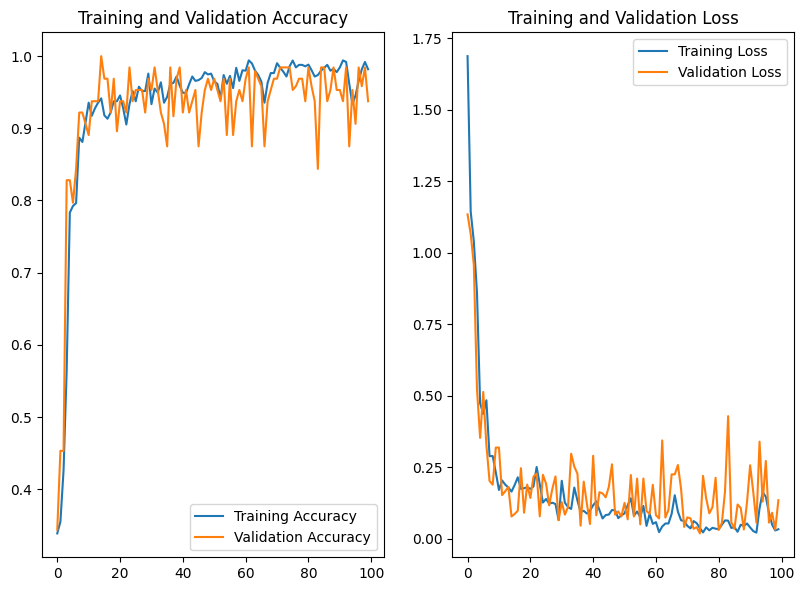

In [190]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
plt.figure(figsize = (15,15))
plt.subplot(2,3,1)
plt.plot(range(epocas), train_acc, label = 'Training Accuracy')
plt.plot(range(epocas), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2,3,2)
plt.plot(range(epocas), train_loss, label = 'Training Loss')
plt.plot(range(epocas), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')



1/1 [==============================] - 0s 32ms/step


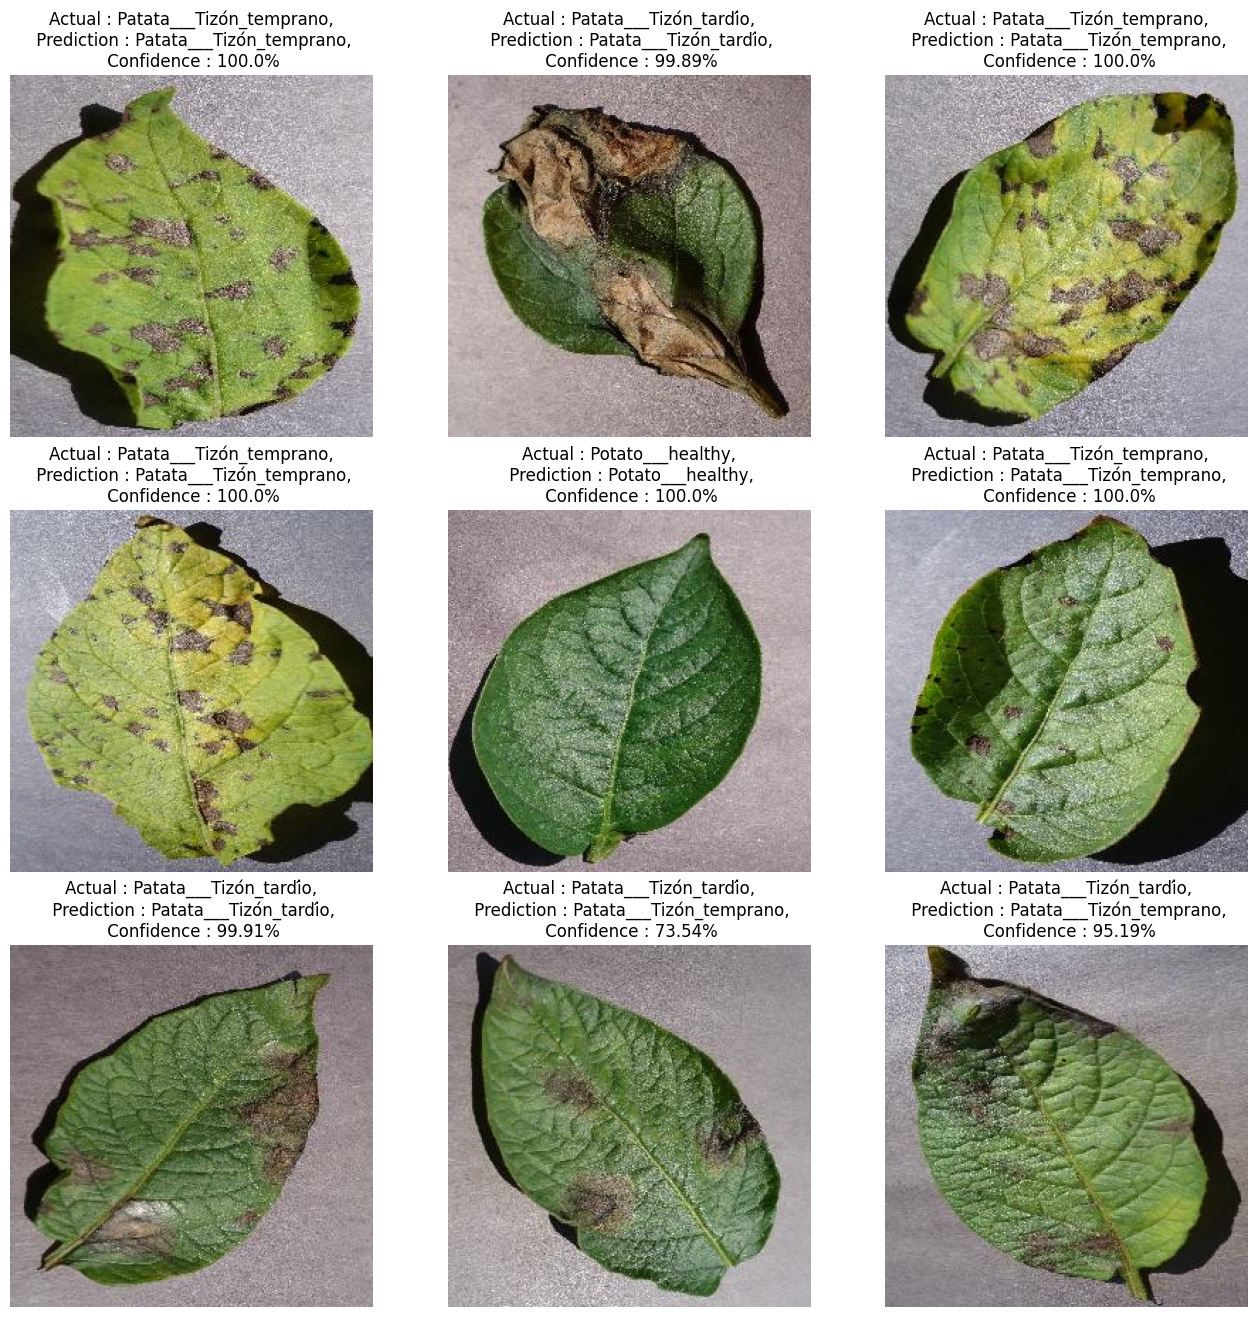

In [191]:
# plotting batch of images with its actual label, predicted label and confidence
plt.figure(figsize = (16,16))
for batch_image, batch_label in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        image = batch_image[i].numpy().astype('uint8')
        label = clases[batch_label[i]]

        plt.imshow(image)

        batch_prediction = modelo_cnn.predict(batch_image)
        predicted_class = clases[np.argmax(batch_prediction[i])]
        confidence = round(np.max(batch_prediction[i]) * 100, 2)

        plt.title(f'Actual : {label},\n Prediction : {predicted_class},\n Confidence : {confidence}%')

        plt.axis('off')

In [192]:
actual_labels = []
predicted_labels = []

for batch_image, batch_label in train_data:
    batch_prediction = modelo_cnn.predict(batch_image)
    predicted_classes = np.argmax(batch_prediction, axis=1)

    actual_labels.extend(batch_label.numpy())
    predicted_labels.extend(predicted_classes)

actual_labels = np.array(actual_labels)
predicted_labels = np.array(predicted_labels)
print(actual_labels)
print(predicted_labels)

1/1 [==============================] - 0s 42ms/step
[0 1 0 1 0 1 2 0 1 1 1 1 1 2 1 1 0 2 0 1 1 1 1 2 0 0 0 2 1 0 2 1 2 1 1 1 1
 0 0 0 1 2 2 2 1 1 0 1 2 1 0 0 0 1 1 1 2 2 0 0 1 0 1 2 0 2 1 0 0 2 1 1 2 0
 0 0 2 2 0 1 2 0 1 0 0 0 1 1 0 1 0 0 0 0 0 2 1 0 0 2 1 1 2 0 1 0 1 2 1 1 0
 1 2 1 2 0 2 0 0 1 2 2 0 1 0 1 0 1 2 0 0 1 1 2 1 0 1 0 2 0 1 1 2 0 2 0 1 0
 1 0 0 1 1 0 1 2 1 0 0 0 0 1 0 0 2 1 1 0 1 0 0 1 2 0 1 1 0 1 1 0 1 1 0 1 2
 0 0 0 0 0 0 0 2 0 1 0 0 1 1 1 0 1 1 0 2 0 2 1 1 0 1 1 1 1 2 1 1 1 2 1 0 0
 0 2 0 1 0 1 0 0 0 0 0 1 2 1 0 1 0 1 1 1 0 1 1 0 2 0 1 0 1 1 0 2 2 0 1 2 0
 0 0 0 1 2 0 1 2 1 1 1 0 1 0 1 2 1 0 2 1 1 0 0 0 2 1 1 2 2 0 0 0 1 1 2 0 0
 2 1 2 0 2 1 1 2 1 1 0 0 0 1 2 1 0 1 0 1 2 0 0 1 0 0 0 1 0 0 1 2 2 1 1 0 0
 2 0 2 0 1 0 0 2 1 2 0 1 1 2 0 1 2 1 0 1 0 2 0 1 1 1 0 0 1 1 1 1 2 2 0 1 1
 1 0 1 0 0 0 1 2 1 2 1 1 1 0 2 1 1 2 0 0 0 1 0 2 2 0 0 1 2 0 0 1 0 0 1 1 2
 0 1 0 0 1 1 0 2 0 2 1 1 2 0 0 1 2 2 0 0 0 0 1 0 1 0 1 2 2 2 0 2 2 0 1 2 0
 1 0 1 0 1 0 1 1 1 0 0 1 0 2 1 1 0 0 1 1 1 1 2 0

In [193]:
print(accuracy_score(actual_labels, predicted_labels))
print(confusion_matrix(actual_labels, predicted_labels))


0.9475806451612904
[[171  22   4]
 [  0 199   0]
 [  0   0 100]]


# **PARA DATOS DE ENTRENAMIENTO DE 50% Y DE TESTEO DE  50%**

In [194]:
#inicializacionde variables
directory="hojas_papa"
size_test=0.5
image_size=256
channels=3
epocas=100
batch_size=32
nro_clases=3


In [195]:
# cargamos los datos
data=tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(image_size, image_size),
   shuffle = True,

)


Found 752 files belonging to 3 classes.


In [196]:
clases=data.class_names
print("clases: ",clases)
print("numero de batches (32 ->1bat): ",len(data))
print(data)


clases:  ['Patata___Tizón_tardío', 'Patata___Tizón_temprano', 'Potato___healthy']
numero de batches (32 ->1bat):  24
<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [197]:
# shuffle_size determina cuántos elementos se toman aleatoriamente del conjunto de datos para realizar la mezcla (todos se mezclan 1000)
def split_dataset(data,train_split=0.4,val_split=0.1,test_split=0.5,shuffle=True,shuffle_size=10000):
  # se mezclan los datos
  if shuffle:
    data=data.shuffle(shuffle_size, seed=10)

  data_size=len(data)
  train_size=int(train_split*data_size)
  val_size=int(val_split*data_size)

  #se extrae con take y skip para omitir los datos selecionados
  train_data=data.take(train_size)
  val_data=data.skip(train_size).take(val_size)
  test_data=data.skip(train_size).skip(val_size)
  return train_data,val_data,test_data

In [198]:
train_data,val_data,test_data=split_dataset(data)

print("data: ",len(data))
print("train: ",len(train_data))
print("val: ",len(val_data))
print("test: ",len(test_data))
print("numero de batches train (32 ->1bat): ",len(train_data))
print(train_data)

data:  24
train:  9
val:  2
test:  13
numero de batches train (32 ->1bat):  9
<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [199]:
# para acelerar el aprendizaje, se optimiza la utilizacion de los recursos de hardware
# El almacenamiento en caché acelera la lectura de los datos desde la memoria, la mezcla aleatoria evita cualquier orden inherente en los datos y la captación previa reduce el tiempo de espera durante el entrenamiento
#prefetch de captación previa para superponer el trabajo de un productor y un consumidor
train_ds=train_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds=val_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds=val_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)

In [200]:

#rescalar y normalizar las imagen
rescalar_normalizar=tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(image_size, image_size),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)

])
aumento_datos_r_v=tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.5)
])


In [201]:
# input_shapes un parámetro que se usa para definir la forma de los datos de entrada a una red neuronal
input_shape=(batch_size,image_size,image_size,channels)

modelo_cnn=models.Sequential([
    rescalar_normalizar,
    aumento_datos_r_v,
    tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'softmax'),
])
modelo_cnn.build(input_shape=input_shape)


In [202]:
modelo_cnn.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_30 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 sequential_31 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_117 (Conv2D)         (32, 254, 254, 16)        448       
                                                                 
 max_pooling2d_108 (MaxPooli  (32, 127, 127, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_118 (Conv2D)         (32, 125, 125, 64)        9280      
                                                                 
 max_pooling2d_109 (MaxPooli  (32, 62, 62, 64)         0         
 ng2D)                                               

In [203]:
from tensorflow.python.training.saver import metrics
#opimizar el modelo
modelo_cnn.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [204]:
#entrenar el modelo
history=modelo_cnn.fit(
    train_data,epochs=epocas,batch_size=batch_size,verbose=1,validation_data=val_data
)

Epoch 1/100
9/9 [==============================] - 6s 251ms/step - loss: 1.8302 - accuracy: 0.3403 - val_loss: 1.2612 - val_accuracy: 0.3333
Epoch 2/100
9/9 [==============================] - 4s 325ms/step - loss: 1.1443 - accuracy: 0.4132 - val_loss: 1.0648 - val_accuracy: 0.4062
Epoch 3/100
9/9 [==============================] - 3s 230ms/step - loss: 0.9844 - accuracy: 0.4306 - val_loss: 0.8735 - val_accuracy: 0.6250
Epoch 4/100
9/9 [==============================] - 3s 239ms/step - loss: 0.6875 - accuracy: 0.6806 - val_loss: 0.5798 - val_accuracy: 0.7656
Epoch 5/100
9/9 [==============================] - 4s 378ms/step - loss: 0.4352 - accuracy: 0.7917 - val_loss: 0.4402 - val_accuracy: 0.7344
Epoch 6/100
9/9 [==============================] - 4s 233ms/step - loss: 0.3409 - accuracy: 0.8566 - val_loss: 0.4133 - val_accuracy: 0.8594
Epoch 7/100
9/9 [==============================] - 4s 381ms/step - loss: 0.5700 - accuracy: 0.7604 - val_loss: 0.6197 - val_accuracy: 0.7500
Epoch 8/100
9

In [206]:
modelo_cnn.save('cnn_100_epocas_v2.h5')

In [207]:
from keras.models import load_model
modelo_cnn = load_model("cnn_100_epocas_v2.h5")

Text(0.5, 1.0, 'Training and Validation Loss')

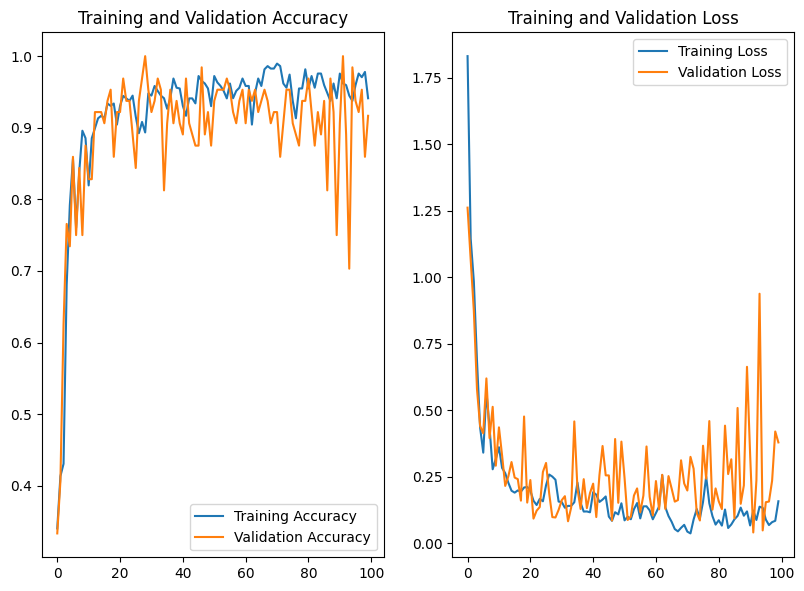

In [208]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
plt.figure(figsize = (15,15))
plt.subplot(2,3,1)
plt.plot(range(epocas), train_acc, label = 'Training Accuracy')
plt.plot(range(epocas), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2,3,2)
plt.plot(range(epocas), train_loss, label = 'Training Loss')
plt.plot(range(epocas), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

In [209]:
actual_labels = []
predicted_labels = []

for batch_image, batch_label in train_data:
    batch_prediction = modelo_cnn.predict(batch_image)
    predicted_classes = np.argmax(batch_prediction, axis=1)

    actual_labels.extend(batch_label.numpy())
    predicted_labels.extend(predicted_classes)

actual_labels = np.array(actual_labels)
predicted_labels = np.array(predicted_labels)
print(actual_labels)
print(predicted_labels)

1/1 [==============================] - 0s 33ms/step
[1 1 1 0 1 1 0 0 0 1 2 1 0 0 0 0 2 1 2 2 1 2 1 0 0 2 0 1 0 0 0 0 0 0 0 2 1
 1 1 2 1 2 2 0 1 2 0 0 0 2 2 0 0 1 1 1 1 2 0 1 1 0 0 2 1 0 1 0 0 0 0 1 1 0
 1 0 0 0 0 2 1 2 1 2 1 2 0 0 0 0 1 1 1 1 0 1 2 1 1 0 1 2 1 2 1 0 1 1 2 0 1
 1 1 0 0 1 1 0 0 1 0 1 1 0 1 0 2 0 0 1 1 0 1 0 1 1 1 0 2 0 1 1 0 0 2 0 2 0
 2 0 1 2 2 1 1 0 1 0 1 0 0 0 0 1 0 0 1 2 0 2 0 0 1 1 1 0 0 0 0 0 0 2 1 1 2
 1 1 1 1 0 1 1 0 2 1 0 0 0 0 0 2 1 1 1 2 2 2 2 0 1 2 0 0 1 2 1 1 1 1 0 1 1
 1 2 1 0 1 1 0 1 1 1 0 1 0 0 2 0 1 1 1 1 0 1 2 0 0 2 1 0 2 2 1 2 1 1 2 1 2
 0 2 0 0 0 1 1 2 0 2 0 0 1]
[1 1 1 1 1 1 0 0 1 1 2 1 0 0 0 0 2 1 2 2 1 2 1 0 0 2 1 1 2 0 0 0 0 0 1 2 1
 1 1 2 1 2 2 0 1 2 0 0 0 2 2 0 0 1 1 1 1 2 1 1 1 0 0 2 1 0 1 2 0 1 0 1 1 0
 1 0 0 0 0 2 1 2 1 2 1 2 0 0 0 0 1 1 1 1 0 1 2 1 1 1 1 2 1 2 1 0 1 1 2 0 1
 1 1 0 0 1 1 0 1 1 0 1 1 0 1 2 2 2 0 1 1 0 1 0 1 1 1 0 2 1 1 1 0 0 2 0 2 0
 2 0 1 2 2 1 1 1 1 0 1 0 0 0 0 1 2 0 1 2 0 2 1 0 1 1 1 1 0 0 0 1 0 2 1 1 2
 1 1 1 1 0 1 1 0 2 1

In [210]:
print(accuracy_score(actual_labels, predicted_labels))
print(confusion_matrix(actual_labels, predicted_labels))

0.9154411764705882
[[ 85  17   6]
 [  0 110   0]
 [  0   0  54]]
